In [84]:
import arviz as az
import numpy as np
from scipy.stats import binom, mode
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from patsy import dmatrix

import warnings
# To remove irritating deprecation warning for Arviz
warnings.filterwarnings('ignore')

# Homework 1

In [37]:
# Problem 1
n = 15
w = 8

p_grid = np.linspace(start=0, stop=1, num=1000)
prior = np.ones(1000)

likelihood = binom.pmf(w, n, p_grid)
posterior = likelihood*prior
posterior = posterior/np.sum(posterior)

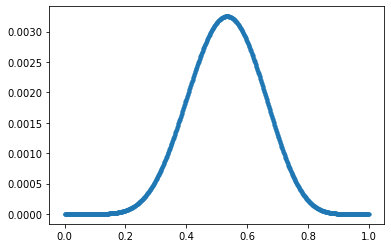

In [39]:
_ = plt.plot(p_grid, posterior, linestyle='--', marker='.')

In [55]:
samples_1 = np.random.choice(p_grid, size=10000, replace=True, p=posterior)

In [56]:
posterior_mean = np.mean(samples_1)
print(f'Posterior mean: {posterior_mean}')

Posterior mean: 0.5285448448448449


In [99]:
left_pi = np.quantile(samples_1, .005)
right_pi = np.quantile(samples_1, .995)
print(f'99% PI: [{left_pi}, {right_pi}]')

99% PI: [0.2272272272272272, 0.804809809809809]


In [100]:
# Problem 2
const = 1
prior_2 = [0 if p < .5 else const for p in p_grid]

posterior_2 = likelihood*prior_2
posterior_2 = posterior_2/np.sum(posterior_2)

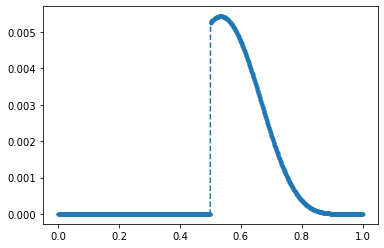

In [105]:
plt.plot(p_grid, posterior_2, linestyle='--', marker='.', label=f'prior -> {const}')
plt.show()

In [103]:
samples_2 = np.random.choice(p_grid, size=10000, replace=True, p=posterior_2)

In [104]:
posterior_2_mean = np.mean(samples_2)
print(f'Posterior mean: {posterior_2_mean}')

Posterior mean: 0.606963063063063


In [106]:
left_pi = np.quantile(samples_2, .005)
right_pi = np.quantile(samples_2, .995)
print(f'99% PI: [{left_pi}, {right_pi}]')

99% PI: [0.5005005005005005, 0.8168218218218211]


# Homework 2

In [3]:
data_path = '/home/jonathan/Projects/LearningReferences/resources/Rethinking_2/Data'
height_df = pd.read_csv(data_path + '/Howell1.csv', sep=';', header=0)

In [80]:
# Problem 1 
data = height_df[height_df.age >= 18]
xbar = data.weight.mean()
weight_pred = [45, 40, 65, 31, 53]
with pm.Model() as lin_height_model:
    weight_obs = pm.Data("weight_obs", data.weight)
    height_obs = pm.Data("height_obs", data.height)
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta*(weight_obs - xbar)
    height_pred = pm.Normal('height_pred', mu=mu, sigma=sigma, observed=height_obs)
    hlin_trace = pm.sample(1000, tune=1000)
    pm.set_data({'weight_obs': weight_pred, 'height_obs': np.zeros(5)})
    post_pred = pm.sample_posterior_predictive(hlin_trace, 500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [82]:
hdi_pred = az.hpd(post_pred['height_pred'], hdi_prob=.89)
mean_pred = np.mean(post_pred['height_pred'], axis=0)

In [83]:
pd.DataFrame({"weight": weight_pred, "height_pred": mean_pred, "hdi_89": np.round(hdi_pred, 2).tolist()})

,weight,height_pred,hdi_89
0,45,154.760416,"[147.28, 162.75]"
1,40,150.285519,"[141.76, 157.8]"
2,65,172.832696,"[164.74, 180.75]"
3,31,142.005959,"[133.33, 149.57]"
4,53,161.715099,"[153.61, 169.82]"


In [86]:
# 2 
knots = 16
knot_list = np.quantile(np.log(height_df.weight), np.linspace(0, 1, knots))
basis_funcs = dmatrix("bs(weight_lg, knots=knot_list, degree=3, include_intercept=True) - 1", 
                      {"weight_lg": np.log(height_df.weight.values), "knot_list": knot_list[1:-1]})

In [96]:
with pm.Model() as bspline_model:
    alpha = pm.Normal("alpha", mu=178, sd=100)
    w_log = pm.Normal("w_log", mu=0, sd=10, shape=basis_funcs.shape[1])
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Deterministic("mu", alpha + pm.math.dot(np.asarray(basis_funcs, order='F'), w_log.T))
    height = pm.Normal("height", mu, sigma, observed=height_df.height)
    bspline_trace = pm.sample(1000, tune=1000)
    post_pred = pm.sample_posterior_predictive(bspline_trace, 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w_log, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


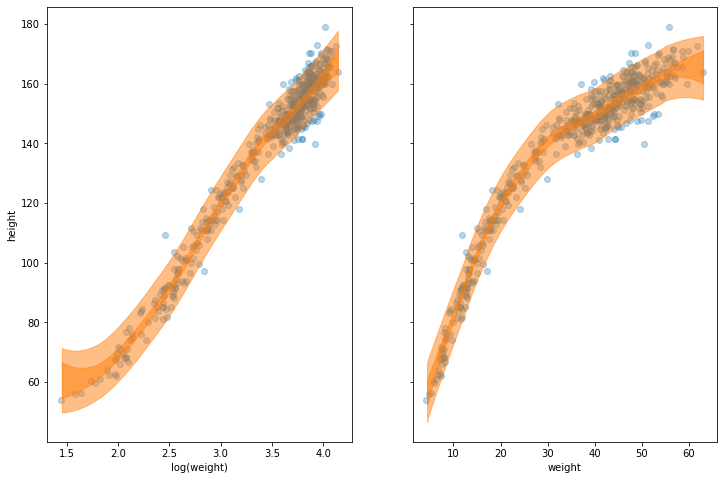

In [116]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
axs[0].scatter(np.log(height_df.weight), height_df.height, alpha=.3)
az.plot_hpd(np.log(height_df.weight), post_pred['height'], ax=axs[0])
az.plot_hpd(np.log(height_df.weight), bspline_trace['mu'], ax=axs[0])
axs[0].set_xlabel('log(weight)')
axs[0].set_ylabel('height')
axs[1].scatter(height_df.weight, height_df.height, alpha=.3)
az.plot_hpd(height_df.weight, post_pred['height'], ax=axs[1])
az.plot_hpd(height_df.weight, bspline_trace['mu'], ax=axs[1])
axs[1].set_xlabel('weight');

In [221]:
# 3
height_df["weight_std"] = (height_df.weight - height_df.weight.mean()) / height_df.weight.std()
height_df["weight_std2"] = height_df.weight_std ** 2

with pm.Model() as poly_height_model:
    a = pm.Normal("a", mu=178, sd=20)
    b1 = pm.Lognormal("b1", mu=2, sd=1)
    b2 = pm.Lognormal("b2", mu=1, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * height_df.weight_std + b2 * height_df.weight_std2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=height_df.height)
    prior_pred = pm.sample_prior_predictive(vars=['height', 'a', 'b1', 'b2', 'sigma', 'mu'])
    poly_height_trace = pm.sample(draws=1000, tune=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [222]:
pm.summary(prior_pred, credible_interval=.89, skipna=True, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
height,182.76,41.43,106.31,261.00
a,178.70,19.24,140.81,211.33
b1,12.51,18.67,0.46,35.64
b2,4.09,4.72,0.16,11.38
sigma,24.89,14.62,0.73,47.64
mu,182.78,29.79,135.13,232.56


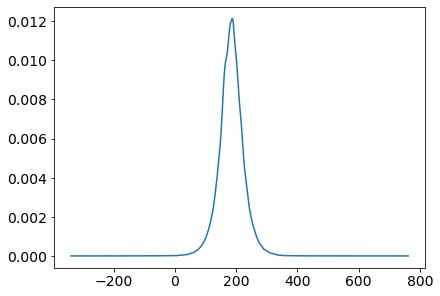

In [223]:
az.plot_kde(prior_pred['height']);

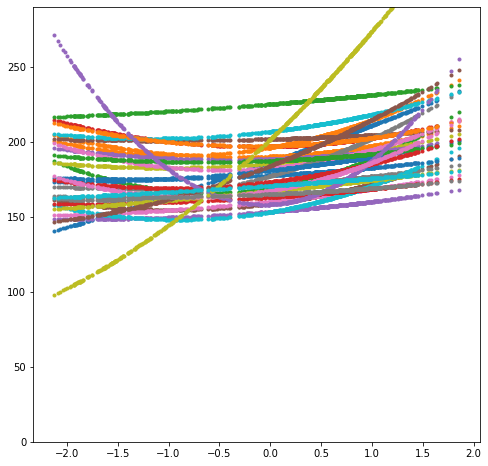

In [224]:
plt.figure(figsize=(8, 8))
plt.ylim([0, 290])
ws = np.linspace(min(height_df.weight_std), max(height_df.weight_std), 1000)
ws2 = np.linspace(min(height_df.weight_std2), max(height_df.weight_std2), 1000)
for i in range(30):
    y = prior_pred['a'][i] + prior_pred['b1'][i]*height_df.weight_std + prior_pred['b2'][i]*height_df.weight_std2
    plt.plot(height_df.weight_std, y, linestyle='None', marker='.')